In [1]:
import pandas as pd
df = pd.read_csv('tweet19.csv', sep=";")
df.head()

,assunto,texto
0,abertura das praias,Não mudou absolutamente NADA!!! Eu já não tenh...
1,abertura das praias,"Na minha opinião, não mudou nada, as pessoas e..."
2,abertura das praias,Uol incentivando as pessoas irem para a praia ...
3,abertura das praias,"Nos ônibus e trens lotados tbm, desde sempre.S..."
4,abertura das praias,novo normal não sei onde... O mais engraçado e...


In [2]:
#df = df[pd.notnull(df['texto'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   assunto  38 non-null     object
 1    texto   38 non-null     object
dtypes: object(2)
memory usage: 736.0+ bytes


In [3]:
#para mais de duas colunas
#col = ['assunto', 'texto']
#df = df[col]
df.columns

Index(['assunto', ' texto'], dtype='object')

In [4]:
df.columns = ['assunto', 'texto']

In [5]:
#criando uma categoria numerica
#Encode the object as an enumerated type or categorical variable.
df['id_categoria'] = df['assunto'].factorize()[0]
#retirar linhas repetidas e ordenar pelo id_categoria
categoria_id_df = df[['assunto','id_categoria']].drop_duplicates().sort_values('id_categoria')
categoria_to_id = dict(categoria_id_df.values)
id_to_categoria = dict(categoria_id_df[['id_categoria', 'assunto']].values)

In [6]:
categoria_id_df

,assunto,id_categoria
0,abertura das praias,0
8,volta as aulas,1
16,vacina,2
25,transporte público,3
32,profissionais,4


In [7]:
categoria_to_id

{'abertura das praias': 0,
 'volta as aulas': 1,
 'vacina': 2,
 'transporte público': 3,
 'profissionais': 4}

In [8]:
id_to_categoria

{0: 'abertura das praias',
 1: 'volta as aulas',
 2: 'vacina',
 3: 'transporte público',
 4: 'profissionais'}

In [9]:
df.head()

,assunto,texto,id_categoria
0,abertura das praias,Não mudou absolutamente NADA!!! Eu já não tenh...,0
1,abertura das praias,"Na minha opinião, não mudou nada, as pessoas e...",0
2,abertura das praias,Uol incentivando as pessoas irem para a praia ...,0
3,abertura das praias,"Nos ônibus e trens lotados tbm, desde sempre.S...",0
4,abertura das praias,novo normal não sei onde... O mais engraçado e...,0


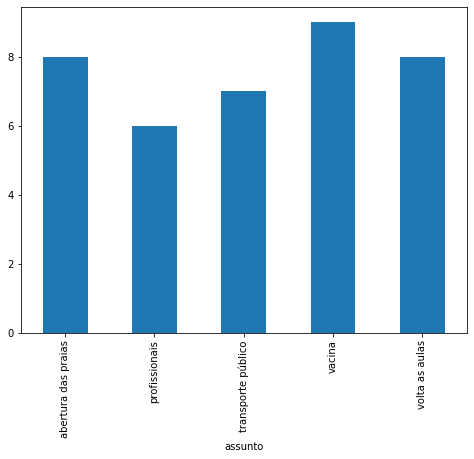

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('assunto').texto.count().plot.bar(ylim=0)
plt.show()

In [11]:
#bag of words
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2,max_df=0.9,ngram_range=(1, 2), stop_words=stopwords.words('portuguese'))

features = tfidf.fit_transform(df.texto).toarray()
labels = df.id_categoria
features.shape

(38, 111)

In [12]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for assunto, id_categoria in sorted(categoria_to_id.items()):
  features_chi2 = chi2(features, labels == id_categoria)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(assunto))
  print("  . Unigrams mais comuns:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Bigrams mais comuns:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'abertura das praias':
  . Unigrams mais comuns:
       . nada
       . praia
  . Bigrams mais comuns:
       . uol deveria
       . novo normal
# 'profissionais':
  . Unigrams mais comuns:
       . profissionais
       . saúde
  . Bigrams mais comuns:
       . health worker
       . profissionais saúde
# 'transporte público':
  . Unigrams mais comuns:
       . transporte
       . público
  . Bigrams mais comuns:
       . aglomerações praias
       . transporte público
# 'vacina':
  . Unigrams mais comuns:
       . quiser
       . vacina
  . Bigrams mais comuns:
       . todo mundo
       . profissionais saúde
# 'volta as aulas':
  . Unigrams mais comuns:
       . aulas
       . idade
  . Bigrams mais comuns:
       . escolas públicas
       . ano letivo


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['texto'], df['assunto'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform(["Como assim as pessoas estão indo as praias!!?"])))

['abertura das praias']


In [15]:
print(clf.predict(count_vect.transform(["Eu não vou mandar meu filho de menos de 3 anos para a escola, ele não tem noção do que é espaço seguro"])))

['vacina']


In [16]:
print(clf.predict(count_vect.transform(["Pela primeira vez na quarentena ontem tive que sair para um exame médico, então pela primeira vez tive que pegar transporte público, e você não pode imaginar quantas pessoas no ônibus, na rua e na própria clínica, que sequer usam mascaras.É uma verdadeira bagunça."])))

['abertura das praias']


In [17]:
df[df['texto'] == "Pela primeira vez na quarentena ontem tive que sair para um exame médico, então pela primeira vez tive que pegar transporte público, e você não pode imaginar quantas pessoas no ônibus, na rua e na própria clínica, que sequer usam mascaras.É uma verdadeira bagunça."]

,assunto,texto,id_categoria
29,transporte público,Pela primeira vez na quarentena ontem tive que...,3


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

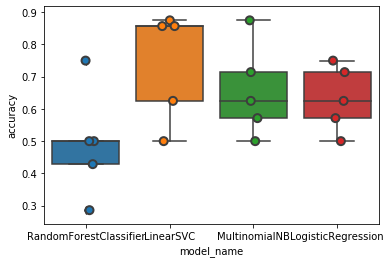

In [19]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [20]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.742857
LogisticRegression        0.632143
MultinomialNB             0.657143
RandomForestClassifier    0.492857
Name: accuracy, dtype: float64

In [21]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

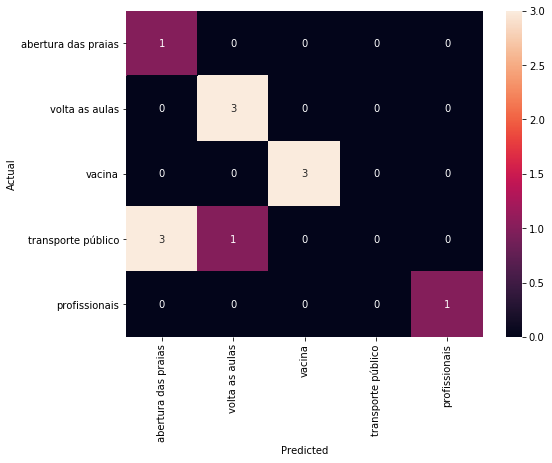

In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categoria_id_df.assunto.values, yticklabels=categoria_id_df.assunto.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
from IPython.display import display

for predicted in categoria_id_df.id_categoria:
  for actual in categoria_id_df.id_categoria:
    if predicted != actual and conf_mat[actual, predicted] >= 1:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_categoria[actual], id_to_categoria[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['assunto', 'texto']])
      print('')

'transporte público' predicted as 'abertura das praias' : 3 examples.


,assunto,texto
29,transporte público,Pela primeira vez na quarentena ontem tive que...
26,transporte público,@Uol deveria mostrar os ônibus lotados e outro...
25,transporte público,O maior risco são os ônibus eo metro e desde ...



'transporte público' predicted as 'volta as aulas' : 1 examples.


,assunto,texto
31,transporte público,pessoa está espirrando e ainda veio sentar no...
